In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

import sklearn
from sklearn.externals import joblib

import neuravi

# Loading dataset

Dataset has been prepared before`

In [2]:
d = neuravi.Data("./data/")

In [3]:
d

# model with TensorFlow and A-G

The past example with scikit-learn directly relates the melt composition and temperature to it's viscosity.

We saw that the problem with this approach is that it underuses our knowledge of how viscosity and temperature vary. This creates too much noise when predicting viscosity over T for one composition.

A way to solve that is to use the neiural net to map the chemical dependence of the parameters that enter into the equation(s) that link viscosity to temperature. As we can use any equation, best if we can actually use the Adam and Gibbs one as it bring thermodynamic information on the melt.

If neural nets work, it should return an internally consistent model that should predict well the entropy and heat capacity of the melt.

Good thing is we know those values for some melts, such that we can trully quantify the success of the neural net.

$a^b$

The viscosity equation is:


$$log(\eta) = A_{e} + \frac{B_{e}}{T \times (S^{conf}(T_{g}) + \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT)}$$ 

where 

$$ \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT = ap \times (log(T) - log(T_{g})) + b \times(T-T_{g}) $$


$A_{e}$ is a constant proportional to the viscosity at infinite temperature. It barely depends on melt composition.

$B_{e}$ is a constant proportional to energy barriers opposed to viscous flow. It strongly depends on melt composition.

S^{conf}(T_{g}) is the configurational entropy of the melt at the glass transition temperature $T_g$ (temperature at which you consider that the melt becomes a glass.

$ap$ and $b$ are parameters that depend on melt composition. We have data and models for those; they nearly linearly depend on melt composition. (this can be discussed for b)

## Approach with neural net

The idea is to link the melt composition (14 variables) to the parameters $A_{e}$, $B_{e}$, $S^{conf}(T_{g})$, $ap$ and $b$ with a neural network.

We can calculate $T_{g}$ as 

$$ T_{g} = \frac{B_{e}}{((12.0-A_{e}) \times S^{conf}(T_{g}))} $$

with the empirical definition that $T_{g}$ occurs when the viscosity reaches around 12 log Pa $\cdot$ s.

This helps removing one parameter and should help to have a self-consistent model.

At this stage, we could use existing models for $ap$ and $b$, but there we assume that those models, which are 30 years old, are good-enough.

Another approach, which I adopt in the following, is to let the neural net determines $ap$ and $b$, such that we can compore those in the future with existing models.

If the neural net is good, we should find consistent results.

## Let's start

First I define the arrays that store the chemical composition and temperature.

viscosity (y values) are already saved in y_train/y_valid/y_test.

In [4]:
d.X_train

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.5440000e+00,  0.0000000e+00,  2.7550000e+03],
       [ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.5440000e+00,  0.0000000e+00,  2.6550000e+03],
       [ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.5440000e+00,  0.0000000e+00,  2.5410000e+03],
       ...,
       [ 7.2000000e-01,  7.0000000e-02,  0.0000000e+00, ...,
        -2.4827016e+00,  9.9148000e-03,  8.9100000e+02],
       [ 7.2000000e-01,  7.0000000e-02,  0.0000000e+00, ...,
        -2.4827016e+00,  9.9148000e-03,  8.7200000e+02],
       [ 7.2000000e-01,  7.0000000e-02,  0.0000000e+00, ...,
        -2.4827016e+00,  9.9148000e-03,  8.5200000e+02]])

In [5]:
# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = d.X_train[:,0:4] # 14 for all dataset, 4 for KNAS
cp_train = d.X_train[:,(4,5)]
temperature_train = d.X_train[:,6].reshape(-1,1)

chimie_valid = d.X_valid[:,0:4]
cp_valid = d.X_valid[:,(4,5)]
temperature_valid = d.X_valid[:,6].reshape(-1,1)

chimie_test = d.X_test[:,0:4]
cp_test = d.X_test[:,(4,5)]
temperature_test = d.X_test[:,6].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

We then create an object to create a network with 1 to 5 layers (ReLu activation units + dropout),

Following the reading of Kaufl, we will initiate the bias of the output neural net layer to values of parameters that are not far from reality.

Then results of output layer are used to calculate the parameters of the A-G equation (see above), which, in turn, gives the viscosity.

We use a L2 loss to determine distance from targets.

Optimizer is RMSprop, it seems the most stable from my test.

The code for the object is in the file neuravi.py

In [6]:
class Model_AG(object):
    """
    derived from  https://github.com/adventuresinML/adventures-in-ml-code/blob/master/weight_init_tensorflow.py
    """
    def __init__(self, input_size, 
                num_layers=3,
                hidden_size=100,
                stdev = 0.01,
                learning_rate = 1e-4):
        
        self._input_size = input_size
        self._num_layers = num_layers # num layers does not include the input layer
        self._hidden_size = hidden_size # all layers have the same number of hidden units
        self._out_size = 4 # fixed regarding the problem shape
        self._init_bias = np.array([np.log(40000.),np.log(5.1),np.log(10.),np.log(0.0001)])
        self._stdev = stdev
        self._learning_rate = learning_rate
        self._model_def()
        
    def _model_def(self):
        # create placeholder variables
        self.input_c = tf.placeholder(dtype=tf.float32, shape=[None,self._input_size], name="chimie")
        self.input_T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")
        self.prob = tf.placeholder_with_default(1.0, shape=())

        if self._num_layers >= 1:
            
            self.Wh1 = tf.Variable(tf.random_normal([self._input_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh1 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.input_c, self.Wh1) + self.bh1),
                                                keep_prob=self.prob,
                                                name="layer1")
            
        if self._num_layers >= 2:
            
            self.Wh2 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh2 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))

            self.hidden_layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_1, self.Wh2) + self.bh2),
                                                keep_prob=self.prob,
                                                name="layer2")
        
        if self._num_layers >= 3:
        
            self.Wh3 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh3 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_2, self.Wh3) + self.bh3),
                                                keep_prob=self.prob,
                                                name="layer3")
            
        if self._num_layers >= 4:
        
            self.Wh4 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh4 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_4 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_3, self.Wh4) + self.bh4),
                                                keep_prob=self.prob,
                                                name="layer4")
            
        if self._num_layers == 5:
        
            self.Wh5 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh5 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_5 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_4, self.Wh5) + self.bh5),
                                                keep_prob=self.prob,
                                                name="layer5")

        self.Wo = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=self._stdev, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias, stddev=self._init_bias*self._stdev, dtype=tf.float32))

        if self._num_layers == 1:
            self.output = tf.add(tf.matmul(self.hidden_layer_1,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 2:
            self.output = tf.add(tf.matmul(self.hidden_layer_2,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 3:
            self.output = tf.add(tf.matmul(self.hidden_layer_3,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 4:
            self.output = tf.add(tf.matmul(self.hidden_layer_4,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 5:
            self.output = tf.add(tf.matmul(self.hidden_layer_5,self.Wo),self.bo,name="out_neurons")
        else:
            print("Error: choose between 1 to 5 layers")
        
        #
        # Adam and Gibbs with network outputs
        #
        #self.ae = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Ae_ph")
        self.be = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Be_ph")
        self.sctg = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ScTg_ph")
        self.ap = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ap_ph")
        self.b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="b_ph")
        
        self.be, self.sctg, self.ap, self.b = tf.split(self.output,4,axis=1)

        self.ae = tf.Variable(tf.zeros([1]),name="Ae")
        
        # cannot be negative
        self.be = tf.exp(self.be,name="Be")
        self.sctg = tf.exp(self.sctg,name="entropy_Tg")
        self.ap = tf.exp(self.ap, name="ap")
        self.b = tf.exp(self.b, name="b")
        
        self.tg = tf.divide(self.be,np.multiply((12.0-self.ae),self.sctg),name="Tg")
        
        self.dCp = tf.add(tf.multiply(self.ap,(tf.log(self.input_T)-tf.log(self.tg))),
                          tf.multiply(self.b,(self.input_T-self.tg)),name="dCp")

        self.entropy = tf.add(self.sctg,self.dCp,name="entropy_T")

        self.denom_n =tf.multiply(self.input_T,self.entropy,name="denominator_AG")
        
        self.visco_pred = tf.add(self.ae,np.divide(self.be,self.denom_n),name="visco_pred")
        
        self.loss = tf.nn.l2_loss(self.visco_pred-self.input_y,name="loss_fct")
                                                                            
        # add the loss to the summary
        tf.summary.scalar('loss', self.loss)
        self.optimizer = tf.train.RMSPropOptimizer(self._learning_rate).minimize(self.loss)
        self.merged = tf.summary.merge_all()
        self.init_op = tf.global_variables_initializer()

In [7]:
NIN = chimie_train.shape[1]
NHIDDEN = 100
NLAYER = 1
STDEV = 0.001

mod = Model_AG(NIN, num_layers=NLAYER,hidden_size=NHIDDEN)

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

OK, no interactive session running


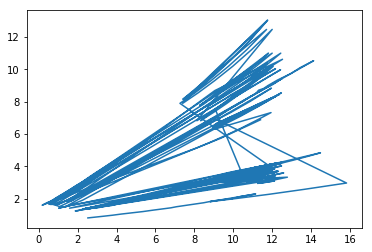

In [8]:
try:
    sess.close()
except:
    print("OK, no interactive session running")

sess = tf.InteractiveSession()
sess.run(mod.init_op)

pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train, 
                                             mod.input_T: temperature_train, 
                                             mod.input_y: d.y_train.reshape(-1,1)})
plt.figure()
plt.plot(d.y_train, pred_ini)

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [9]:
NEPOCH = 10000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, mod.input_T: temperature_train, mod.input_y: d.y_train.reshape(-1,1)}
    dct_valid = {mod.input_c: chimie_valid, mod.input_T: temperature_valid, mod.input_y: d.y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]:
        count_es += 1
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 6060.2509765625, 672.030517578125
Batch train and valid loss at step 500: 3974.79052734375, 258.9619140625
Batch train and valid loss at step 1000: 2489.03369140625, 253.2799835205078
Batch train and valid loss at step 1500: 1663.8785400390625, 216.7955322265625
Batch train and valid loss at step 2000: 897.9400634765625, 112.12773895263672
Batch train and valid loss at step 2500: 766.64404296875, 117.65076446533203
Batch train and valid loss at step 3000: 711.3162841796875, 112.19066619873047
Batch train and valid loss at step 3500: 651.8505249023438, 109.31610870361328
Batch train and valid loss at step 4000: 577.222900390625, 104.91302490234375
Batch train and valid loss at step 4500: 486.7978210449219, 96.68827056884766
Batch train and valid loss at step 5000: 391.79095458984375, 91.98029327392578
Batch train and valid loss at step 5500: 313.4339904785156, 81.29695129394531
Batch train and valid loss at step 6000: 261.680419921875, 73.6790618896

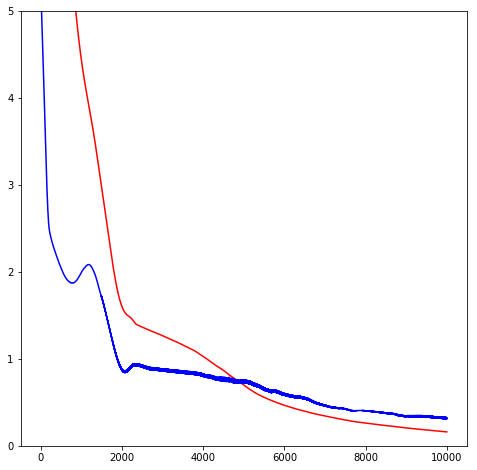

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, NEPOCH,1), loss_train/d.X_train.shape[0], 'r-')
plt.plot(np.arange(0, NEPOCH,1), loss_valid/d.X_valid.shape[0], 'b-')
plt.ylim(0,5)
plt.show()
plt.savefig("epochs_ag.pdf")

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [11]:
name_out = "KNAS_AG_noCp_layer_"+str(NLAYER)+"units_"+str(NHIDDEN)+"it_"+str(NEPOCH)

tf.saved_model.simple_save(sess,
            "./model/"+name_out,
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/KNAS_AG_noCp_layer_1units_100it_10000/saved_model.pb


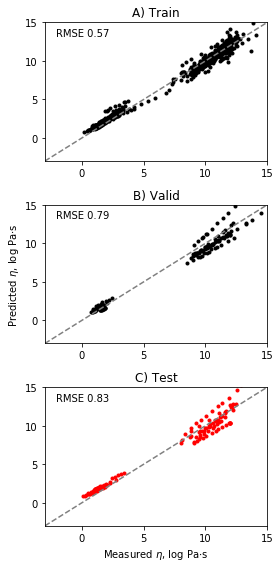

In [12]:
train_pred_out = sess.run(mod.visco_pred,feed_dict=dct_train)
valid_pred_out = sess.run(mod.visco_pred,feed_dict=dct_valid)
test_pred_out = sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_test, 
                 mod.input_T: temperature_test, mod.input_y: d.y_test.reshape(-1,1)})

plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(d.y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_train, train_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(d.y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_valid, valid_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(d.y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_test, test_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()